In [ ]:
!pip install transformers

# **Project 2: Word Embeddings and the Brain**

## **Structured Tasks**

## **Task 3: Brain encoder model**

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # set to eval mode

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        # Mean pooling of last hidden state
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [ ]:
import pickle
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/Structured Task (sentence decoding)"

# Load EXP3 (Experiment 3)
with open(f"{path}/EXP3.pkl", "rb") as f:
    exp3 = pickle.load(f)

X_exp3 = exp3["Fmridata"]                    # shape: (243, 185866)
Y_exp3 = np.loadtxt(f"{path}/vectors_243sentences.GV42B300.average.txt") # shape: (243, 300)
with open(f"{path}/stimuli_243sentences.txt", "r", encoding="utf-8") as f:
    sentences_3 = [line.strip() for line in f.readlines()]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", category=RuntimeWarning)

def single_compute_voxel_r2(v, X_train, X_test, Y_train, Y_test):
    model = LinearRegression()
    y_voxel_train = Y_train[:, v]
    y_voxel_test = Y_test[:, v]
    model.fit(X_train, y_voxel_train)
    y_pred = model.predict(X_test)
    return r2_score(y_voxel_test, y_pred)

def compute_voxel_r2(X, Y, method_label, test_size=0.2, random_state=42, n_jobs=-1):
    n_voxels = Y.shape[1]

    # Train/test split once
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    # Parallel computation with progress bar
    voxels = list(range(n_voxels))
    r2_scores = Parallel(n_jobs=n_jobs)(
        delayed(single_compute_voxel_r2)(v, X_train, X_test, Y_train, Y_test)
        for v in tqdm(voxels, desc=f"Encoding ({method_label})")
    )

    return np.array(r2_scores)

In [ ]:
bert_vectors_3 = np.stack([get_bert_embedding(s) for s in sentences_3])  # shape: (243, 768)
r2_glove = compute_voxel_r2(Y_exp3, X_exp3, 'Glove')
r2_bert = compute_voxel_r2(bert_vectors_3, X_exp3, 'Bert')

Encoding (Bert): 100%|██████████| 185866/185866 [46:44<00:00, 66.27it/s]


GloVe:
  Total voxels: 185866
  Voxels with R² > 0: 2 (0.00%)
  Mean R² (positive only): 0.0310

BERT:
  Total voxels: 185866
  Voxels with R² > 0: 1427 (0.77%)
  Mean R² (positive only): 0.0640



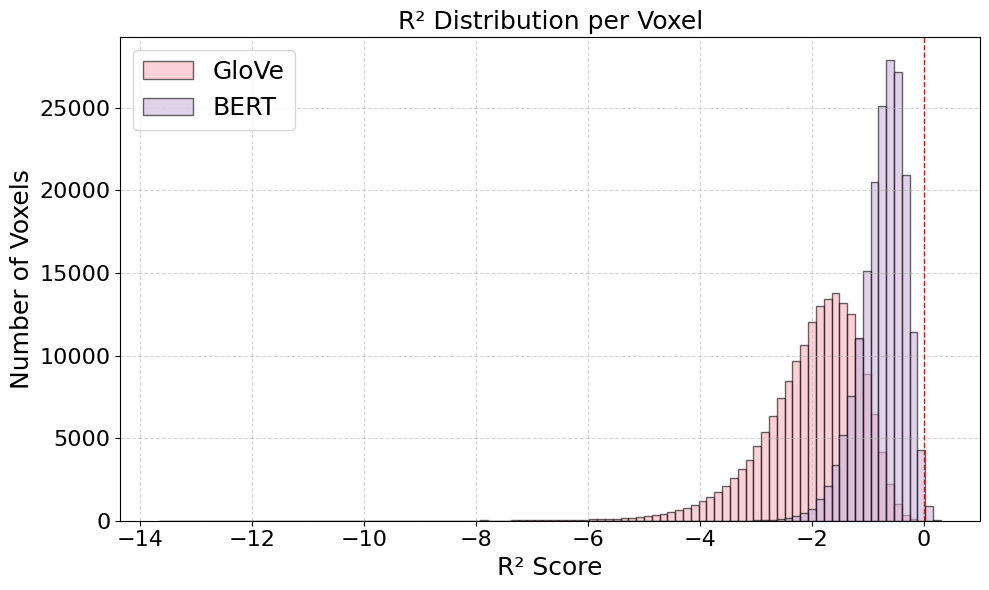

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def summarize_r2_dual_fixed(r2_1, label_1, r2_2, label_2, bins=100):
    # Summary stats
    def print_stats(r2, label):
        n_total = len(r2)
        n_positive = np.sum(r2 > 0)
        mean_r2 = np.mean(r2[r2 > 0]) if n_positive > 0 else 0
        print(f"{label}:")
        print(f"  Total voxels: {n_total}")
        print(f"  Voxels with R² > 0: {n_positive} ({n_positive / n_total:.2%})")
        print(f"  Mean R² (positive only): {mean_r2:.4f}")
        print()

    print_stats(r2_1, label_1)
    print_stats(r2_2, label_2)

    # Compute common bin edges
    r2_min = min(r2_1.min(), r2_2.min())
    r2_max = max(r2_1.max(), r2_2.max())
    bin_edges = np.linspace(r2_min, r2_max, bins+1)

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(r2_1, bins=bin_edges, alpha=0.6, label=label_1, edgecolor='black', color ="#fbb1bd" )
    plt.hist(r2_2, bins=bin_edges, alpha=0.6, label=label_2, edgecolor='black', color ="#cdb4db" )
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("R² Score", fontsize=18)
    plt.ylabel("Number of Voxels", fontsize=18)
    plt.title("R² Distribution per Voxel", fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
summarize_r2_dual_fixed(r2_glove, "GloVe", r2_bert, "BERT")

## Save and load results

In [ ]:
#save r2_glove and r2_bert

# Save the R2 scores to files
with open(f"r2_glove.pkl", "wb") as f:
    pickle.dump(r2_glove, f)

with open(f"r2_bert.pkl", "wb") as f:
    pickle.dump(r2_bert, f)

print("r2_glove and r2_bert saved successfully.")

r2_glove and r2_bert saved successfully.


In [ ]:
import pickle
# load r2 files
with open(f"r2_glove.pkl", "rb") as f:
    r2_glove = pickle.load(f)
with open(f"r2_bert.pkl", "rb") as f:
    r2_bert = pickle.load(f)